In [2]:
import nltk
import spacy
from nltk.tokenize.toktok import ToktokTokenizer
from ebooklib import epub
import ebooklib
from bs4 import BeautifulSoup
import re
import itertools
import matplotlib.pyplot as plt
import numpy as np
from contractions import CONTRACTION_MAP
import unicodedata
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [4]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


In [5]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [6]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


In [7]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [8]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [9]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


In [10]:
def normalize_corpus(corpus,contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=False, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [11]:
book = epub.read_epub('wok.epub')

In [12]:
toc = book.get_item_with_id('con01')

toc_pageSource = toc.get_content().decode('utf-8')

soup = BeautifulSoup(toc_pageSource, 'html.parser')

chapters = { file['id'].replace('a',''):{'chapterName':re.sub(".*\: ","",file.text)} for file in soup.find_all('a') if 'id' in file.attrs  }

for k in ['pt01','pt02','pt03','pt04','pt05','pt06','pt07','pt08','pt09',]:
    chapters.pop(k,None)
    
print(chapters)

{'fm02': {'chapterName': 'Prelude to the Stormlight Archive'}, 'ch01': {'chapterName': 'To Kill'}, 'ch02': {'chapterName': 'STORMBLESSED'}, 'ch03': {'chapterName': 'HONOR IS DEAD'}, 'ch04': {'chapterName': 'CITY OF BELLS'}, 'ch05': {'chapterName': 'THE SHATTERED PLAINS'}, 'ch06': {'chapterName': 'HERETIC'}, 'ch07': {'chapterName': 'BRIDGE FOUR'}, 'ch08': {'chapterName': 'ANYTHING REASONABLE'}, 'ch09': {'chapterName': 'NEARER THE FLAME'}, 'ch10': {'chapterName': 'DAMNATION'}, 'ch11': {'chapterName': 'STORIES OF SURGEONS'}, 'ch12': {'chapterName': 'DROPLETS'}, 'ch13': {'chapterName': 'ISHIKK'}, 'ch14': {'chapterName': 'NAN BALAT'}, 'ch15': {'chapterName': 'THE GLORY OF IGNORANCE'}, 'ch16': {'chapterName': 'UNITY'}, 'ch17': {'chapterName': 'TEN HEARTBEATS'}, 'ch18': {'chapterName': 'PAYDAY'}, 'ch19': {'chapterName': 'THE DECOY'}, 'ch20': {'chapterName': 'COCOONS'}, 'ch21': {'chapterName': 'A BLOODY, RED SUNSET'}, 'ch22': {'chapterName': 'HIGHPRINCE OF WAR'}, 'ch23': {'chapterName': 'STARF

In [28]:
for chId in chapters:
    item = book.get_item_with_id(chId)
    pageSource = item.get_content().decode('utf-8')
    soup = BeautifulSoup(pageSource, 'html.parser')
    chapters[chId]['chapterHead'] = [ sent for para in soup.find('div',attrs={'class':'chapterHead'}).find_all('p') for sent in para.text.strip().split('. ')]
    chapters[chId]['chapterBody'] = [ sent for para in soup.find('div',attrs={'class':'chapterBody'}).find_all('p') for sent in para.text.strip().split('. ')]
    print(chId,len(chapters[chId]['chapterHead']),len(chapters[chId]['chapterBody']))
print(chapters['ch01']['chapterHead'])
    

fm02 0 153
ch01 8 496
ch02 6 430
ch03 6 468
ch04 7 382
ch05 5 376
ch06 6 363
ch07 6 661
ch08 7 537
ch09 4 617
ch10 4 236
ch11 1 193
ch12 4 332
ch13 1 197
ch14 1 107
ch15 1 188
ch16 3 686
ch17 5 303
ch18 4 379
ch19 3 861
ch20 1 565
ch21 3 645
ch22 3 793
ch23 4 571
ch24 1 87
ch25 2 490
ch26 3 516
ch27 4 531
ch28 2 335
ch29 1 306
ch30 6 559
ch31 3 858
ch32 7 886
ch33 1 263
ch34 1 200
ch35 1 287
ch36 4 630
ch37 6 367
ch38 1 194
ch39 5 446
ch40 6 540
ch41 4 212
ch42 5 175
ch43 5 473
ch44 1 587
ch45 4 203
ch46 5 320
ch47 5 519
ch48 1 204
ch49 4 530
ch50 4 512
ch51 1 484
ch52 5 737
ch53 5 742
ch54 1 485
ch55 4 353
ch56 4 345
ch57 5 134
ch58 1 201
ch59 1 136
ch60 1 147
ch61 1 252
ch62 6 673
ch63 5 258
ch64 6 531
ch65 5 564
ch66 9 383
ch67 6 888
ch68 5 674
ch69 7 638
ch70 6 425
ch71 4 336
ch72 5 492
ch73 7 219
ch74 4 311
ch75 8 331
ch76 5 220
ch77 5 817
ch78 9 631
ch79 8 751
ch80 1 264
ch81 1 255
ch82 1 96
ch83 1 370
ch84 1 99
ch85 1 225
bm01 1 147
end01 1 13
bm02 0 67
['', '“The love of men is

In [30]:
corpus = []
for chapter in chapters:
    corpus.append(chapters[chapter]['chapterName'])
    corpus.extend(chapters[chapter]['chapterHead'])
    corpus.extend(chapters[chapter]['chapterBody'])

corpus[0:10]

['Prelude to the Stormlight Archive',
 'Kalak rounded a rocky stone ridge and stumbled to a stop before the body of a dying thunderclast',
 'The enormous stone beast lay on its side, riblike protrusions from its chest broken and cracked',
 'The monstrosity was vaguely skeletal in shape, with unnaturally long limbs that sprouted from granite shoulders',
 'The eyes were deep red spots on the arrowhead face, as if created by a fire burning deep within the stone',
 'They faded.',
 'Even after all these centuries, seeing a thunderclast up close made Kalak shiver',
 'The beast’s hand was as long as a man was tall',
 'He’d been killed by hands like those before, and it hadn’t been pleasant.',
 'Of course, dying rarely was.']

In [32]:
clean_corpus = normalize_corpus(corpus)
clean_corpus[0:10]

['prelude stormlight archive',
 'kalak round rocky stone ridge stumble stop body die thunderclast',
 'enormous stone beast lie side riblike protrusion chest break crack',
 'monstrosity vaguely skeletal shape unnaturally long limb sprout granite shoulder',
 'eye deep red spot arrowhead face create fire burn deep within stone',
 'fade',
 'even century see thunderclast close make kalak shiver',
 'beast hand long man tall',
 'would kill hand like not pleasant',
 'course die rarely']

In [33]:
tokenised_sentences = [ sent.split() for sent in clean_corpus ]
vocab = list(set(sorted([ tok for sent in tokenised_sentences for tok in sent])))
print( "|N|="+str(len(tokenised_sentences))+"|V|="+str(len(vocab)) )


|N|=36884|V|=11922


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


{'prelude': <gensim.models.keyedvectors.Vocab object at 0x13e5fca20>, 'stormlight': <gensim.models.keyedvectors.Vocab object at 0x13d945048>, 'archive': <gensim.models.keyedvectors.Vocab object at 0x13f9c4ba8>, 'kalak': <gensim.models.keyedvectors.Vocab object at 0x13f9c4c18>, 'round': <gensim.models.keyedvectors.Vocab object at 0x13f9c4cf8>, 'rocky': <gensim.models.keyedvectors.Vocab object at 0x13f9c4d30>, 'stone': <gensim.models.keyedvectors.Vocab object at 0x13f9c4d68>, 'ridge': <gensim.models.keyedvectors.Vocab object at 0x13f9c4da0>, 'stumble': <gensim.models.keyedvectors.Vocab object at 0x13f9c4dd8>, 'stop': <gensim.models.keyedvectors.Vocab object at 0x13f9c4e10>, 'body': <gensim.models.keyedvectors.Vocab object at 0x13f9c4e48>, 'die': <gensim.models.keyedvectors.Vocab object at 0x13f9c4e80>, 'thunderclast': <gensim.models.keyedvectors.Vocab object at 0x13f9c4eb8>, 'enormous': <gensim.models.keyedvectors.Vocab object at 0x13f9c4ef0>, 'beast': <gensim.models.keyedvectors.Vocab o

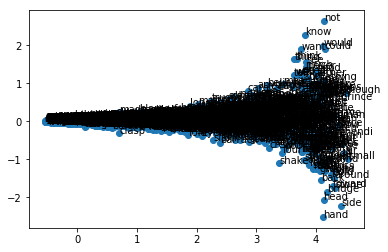

In [34]:
model = Word2Vec(tokenised_sentences, min_count=1)
X = model[model.wv.vocab]

pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])

words = list(model.wv.vocab)

for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    
plt.show()